# EN >ZH & EN > DE RDMs Tests: Comparing embeddings and creating the .CSV file

## Data Preprocessing using the MLQE-PE dataset

In [1]:
import pandas as pd

# Replace these file names with their actual paths if needed
src_file = 'train.src'
mt_file = 'train.mt'
pe_file = 'train.pe'
hter_file = 'train.hter'
output_csv = 'combined_mlqe_de.csv'

# Read lines from each file
with open(src_file, 'r', encoding='utf-8') as f_src, \
     open(mt_file, 'r', encoding='utf-8') as f_mt, \
     open(pe_file, 'r', encoding='utf-8') as f_pe, \
     open(hter_file, 'r', encoding='utf-8') as f_hter:

    # Zip the lines from each file together
    rows = []
    for s_line, m_line, p_line, h_line in zip(f_src, f_mt, f_pe, f_hter):
        # Strip trailing newlines/spaces and append to rows
        rows.append([
            s_line.strip(),
            m_line.strip(),
            p_line.strip(),
            h_line.strip()
        ])

# Create a DataFrame and save as CSV
df = pd.DataFrame(rows, columns=['src', 'mt', 'pe', 'hter'])
df.to_csv(output_csv, index=False)

print(f"Combined CSV saved as {output_csv}")

Combined CSV saved as combined_mlqe_de.csv


# EN > DE

## Comparing RDMs for EN-ZH using the MLQE-PE dataset

In [2]:
!pip install rsatoolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.3/710.3 kB 20.0 MB/s eta 0:00:00


In [3]:
"""
Given a pair of sentences, this script creates the RDMs for each sentence using
the RSA toolbox and returns the Kendall tau correlation between them, plus an
HTER value and the actual sentences aligned with each row.
"""

import numpy
import rsatoolbox
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from torch import Tensor
from torch import eye, matmul
from rsatoolbox.vis.rdm_plot import show_rdm
from rsatoolbox.rdm.rdms import RDMs
from torch.nn.functional import pad

model_name = "FacebookAI/xlm-roberta-base"

def project_embedding(embeddings: Tensor, dim: int = 2, start=0):
    """
    Projects a 2D slice from the embedding dimension for visualization
    or dimensionality reduction.
    """
    projectionMatrix = pad(
        eye(dim),
        (0, embeddings.shape[0], start, (embeddings.shape[1] - start) - dim),
        value=0
    )

    result = matmul(embeddings, projectionMatrix)[:, :dim]
    return result.numpy(force=True)

def define_model_tokenizer(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    return tokenizer, model

def rsa_rdm(
    src_sent: list,    # source sentences
    out_sent: list,    # system (MT) output sentences
    ref_sent: list,    # reference (gold) sentences
    hter_sent: list,   # HTER scores aligned per sentence
    model_name: str
):
    """
    Calculates the RSA-based RDMs for each triple of source, system-output,
    and reference sentences, and computes Kendall tau correlations
    between each pair of RDMs.
    Also appends HTER and the raw sentences (src, mt, pe) in the same row.
    """

    # Prepare tokenizer and model
    tokenizer, model = define_model_tokenizer(model_name)

    Results = []
    for i in range(len(src_sent)):
        # Tokenize
        la_example_out = tokenizer(
            out_sent[i], return_tensors='pt', padding='max_length', max_length=512, truncation=True
        )
        la_example_ref = tokenizer(
            ref_sent[i], return_tensors='pt', padding='max_length', max_length=512, truncation=True
        )
        la_example_src = tokenizer(
            src_sent[i], return_tensors='pt', padding='max_length', max_length=512, truncation=True
        )

        # Decode to get token labels (optional, mainly for debugging or visualization)
        la_labels_out = [tokenizer.decode(tok_id.item()) for tok_id in la_example_out['input_ids'][0]]
        la_labels_ref = [tokenizer.decode(tok_id.item()) for tok_id in la_example_ref['input_ids'][0]]
        la_labels_src = [tokenizer.decode(tok_id.item()) for tok_id in la_example_src['input_ids'][0]]

        # Determine valid lengths (trim padding to keep dimension consistent)
        max_len = max(
            len([x for x in la_labels_out if x != "[PAD]"]),
            len([x for x in la_labels_ref if x != "[PAD]"]),
            len([x for x in la_labels_src if x != "[PAD]"])
        )
        la_labels_out = la_labels_out[:max_len]
        la_labels_ref = la_labels_ref[:max_len]
        la_labels_src = la_labels_src[:max_len]

        # Extract the token embeddings (first hidden state is the input embeddings)
        embeddings_out = model(**la_example_out, output_hidden_states=True)['hidden_states'][0][0][:max_len]
        embeddings_ref = model(**la_example_ref, output_hidden_states=True)['hidden_states'][0][0][:max_len]
        embeddings_src = model(**la_example_src, output_hidden_states=True)['hidden_states'][0][0][:max_len]

        # Random dimension offset for projection
        rand_dim = numpy.random.randint(low=0, high=embeddings_out.shape[1] - 2)

        projection_out = project_embedding(embeddings_out, start=rand_dim)
        projection_ref = project_embedding(embeddings_ref, start=rand_dim)
        projection_src = project_embedding(embeddings_src, start=rand_dim)

        # Create RDMs for each set of embeddings
        rdm_out = rsatoolbox.rdm.calc_rdm(rsatoolbox.data.Dataset(embeddings_out.detach().numpy()))
        rdm_ref = rsatoolbox.rdm.calc_rdm(rsatoolbox.data.Dataset(embeddings_ref.detach().numpy()))
        rdm_src = rsatoolbox.rdm.calc_rdm(rsatoolbox.data.Dataset(embeddings_src.detach().numpy()))

        # Optional pattern descriptors (for labeling or visualization)
        rdm_out.pattern_descriptors = {'index': la_labels_out}
        rdm_ref.pattern_descriptors = {'index': la_labels_ref}
        rdm_src.pattern_descriptors = {'index': la_labels_src}

        # Compare RDMs with Kendall's tau
        src_out = float(rsatoolbox.rdm.compare_kendall_tau(rdm_src, rdm_out)[0][0])
        src_ref = float(rsatoolbox.rdm.compare_kendall_tau(rdm_src, rdm_ref)[0][0])
        out_ref = float(rsatoolbox.rdm.compare_kendall_tau(rdm_out, rdm_ref)[0][0])

        # -----------------------------------------------------------
        # Append results: (index, correlations, hter, src, mt, ref)
        # -----------------------------------------------------------
        tuple_results = (
            i,
            src_out,
            src_ref,
            out_ref,
            hter_sent[i],
            src_sent[i],
            out_sent[i],
            ref_sent[i]
        )
        Results.append(tuple_results)

    return Results

In [ ]:
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 13.2 MB/s eta 0:00:00


In [4]:
import pandas as pd

df = pd.read_csv("/content/combined_mlqe_de.csv")

df = df.sample(n=2000, random_state=42)
df = df.reset_index(drop=True)

source_en_sentences = df['src']
out_zh_sentences = df['mt']
ref_zh_sentences = df['pe']

# HTER is read into a separate list
hter = df['hter']

# define model name
model_name = "FacebookAI/xlm-roberta-base"

# Call rsa_rdm with HTER as an argument
results = rsa_rdm(
    src_sent=source_en_sentences,
    out_sent=out_zh_sentences,
    ref_sent=ref_zh_sentences,
    hter_sent=hter,
    model_name=model_name
)

# Create DataFrame with eight columns, including src, mt, pe
results_df = pd.DataFrame(
    results,
    columns=[
        'idx',      # index from the loop
        'src_out',  # Kendall tau corr: source vs. MT output
        'src_ref',  # Kendall tau corr: source vs. reference
        'out_ref',  # Kendall tau corr: MT output vs. reference
        'hter',     # HTER value
        'src',      # actual source sentence
        'mt',       # actual MT output sentence
        'pe'        # actual reference sentence
    ]
)

results_df.to_csv('results_DE.csv', index=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [5]:
results_df.head()

,idx,src_out,src_ref,out_ref,hter,src,mt,pe
0,0,0.935326,0.935786,0.921220,0.380952,He scored 34 and 26 and took two wickets in ea...,Er erzielte 34 und 26 und nahm zwei Pforten in...,Er erzielte 34 und 26 und nahm in jedem Inning...
1,1,0.950000,0.916275,0.910917,0.083333,Two .303 in Brownings were fitted to aid aimin...,Zwei .303 in Browenings wurden zur Unterstützu...,Zwei .303 in Browenings wurden zur Unterstützu...
2,2,0.858885,0.844192,0.941856,0.187500,Average daily and weekday ridership also set n...,Die durchschnittliche Tages- und Wochentagszug...,Die durchschnittlichen Tages- und Wochentags-F...
3,3,0.951553,0.981156,0.965169,0.181818,"In February 2016 , Mattel unveiled a Barbie do...",Im Februar 2016 enthüllte Mattel eine Barbie-P...,Im Februar 2016 enthüllte Mattel eine Barbie-P...
4,4,0.861399,0.861399,1.000000,0.000000,Conglomerate Tyco International lent its chief...,Der Konglomerat Tyco International verlieh sei...,Der Konglomerat Tyco International verlieh sei...


## RSA Score compared to HTER: DE

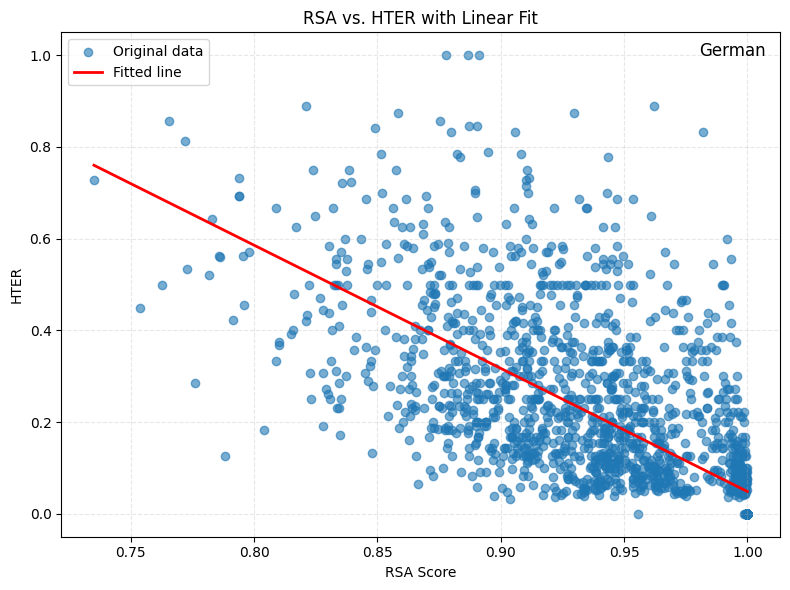

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# 1) Load your data
df = pd.read_csv('/content/results_DE.csv')
#    expected columns: idx, src_out, src_ref, out_ref, hter, src, mt, pe, rsa

# 2) Extract x / y
x = df['out_ref'].values
y = df['hter'].values

# 3) Scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, alpha=0.6, label='Original data')

# 4) Linear fit
slope, intercept = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='red', linewidth=2, label='Fitted line')

# 5) Labels & legend
ax.set_xlabel('RSA Score')
ax.set_ylabel('HTER')
ax.set_title('RSA vs. HTER with Linear Fit')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

ax.text(0.98, 0.98, "German",
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=12,)

plt.tight_layout()
plt.show()

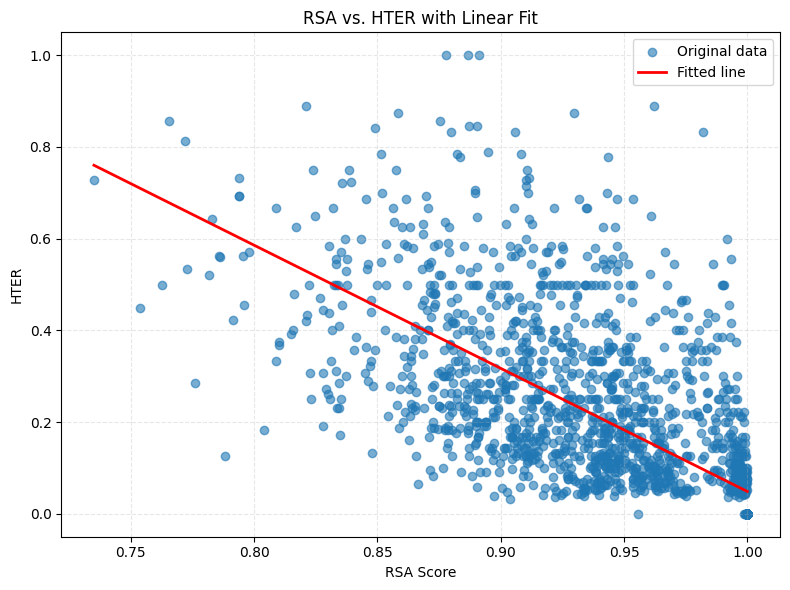

In [8]:
# 2) Scatter
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.6, label='Original data')

# 3a) Fit a line via numpy.polyfit
slope, intercept = np.polyfit(x, y, 1)

# 3b) Create a smooth x‐axis for plotting the line
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

# 4) Plot the fitted line
ax.plot(x_line, y_line, '-', color='red', linewidth=2, label='Fitted line')

# 5) Labels & legend
ax.set_xlabel('RSA Score')
ax.set_ylabel('HTER')
ax.set_title('RSA vs. HTER with Linear Fit')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## chrF: DE

In [9]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 13.3 MB/s eta 0:00:00


In [12]:
###############################################################################
# (A) COMPUTE chrF AND SAVE chrF‑vs‑HTER CSV
###############################################################################
import pandas as pd
import sacrebleu

df = (pd.read_csv("results_DE.csv")
      .head(2000)
      .reset_index(drop=True)
)

chrf = sacrebleu.metrics.CHRF(beta=2)

out_ref_scores = []
for pe, mt in zip(df["pe"], df["mt"]):
    score = chrf.sentence_score(mt, [pe]).score / 100
    out_ref_scores.append(score)

out_df = pd.DataFrame({
    "src":      df["src"],
    "mt":       df["mt"],
    "pe":       df["pe"],
    "out_ref":  out_ref_scores,
    "hter":     df["hter"]
})

out_df.to_csv("chrf_vs_hter.csv", index=False)
print(f"Wrote {len(out_df)} rows → chrf_vs_hter.csv")

Wrote 2000 rows → chrf_vs_hter.csv


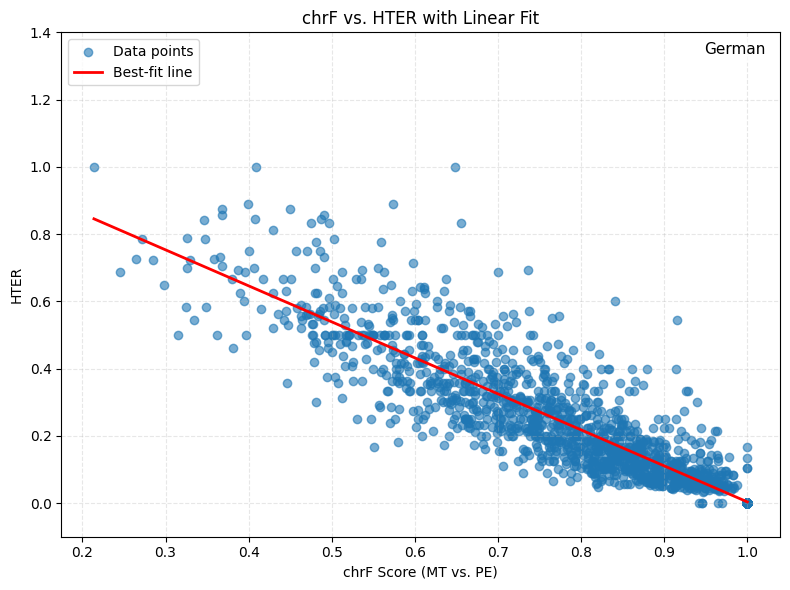

In [24]:
###############################################################################
# (B) PLOT chrF vs. HTER
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv("chrf_vs_hter.csv")

x = df["out_ref"].values
y = df["hter"].values

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.set_ylim(-0.1, 1.4)
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.text(0.98, 0.98, "German", transform=ax.transAxes,
        fontsize=11, ha="right", va="top",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.set_xlabel("chrF Score (MT vs. PE)")
ax.set_ylabel("HTER")
ax.set_title("chrF vs. HTER with Linear Fit")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


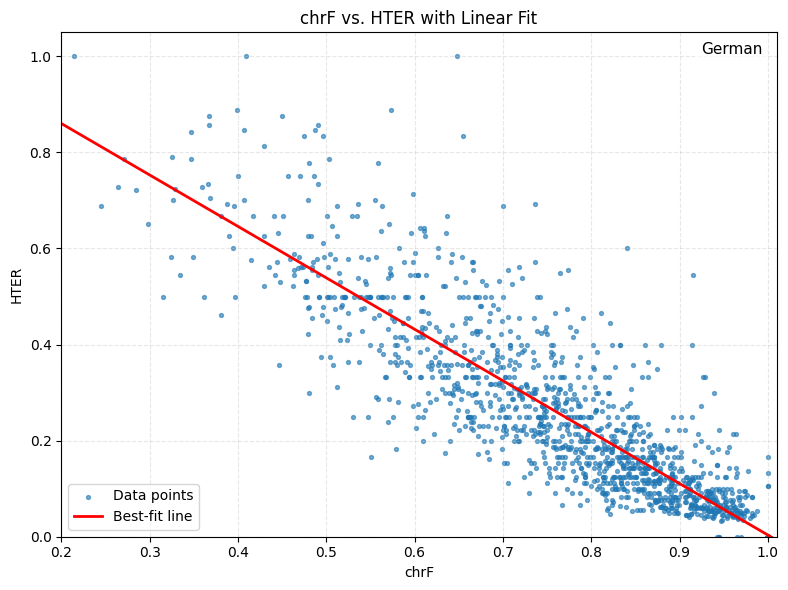

In [23]:
###############################################################################
# (B) PLOT BERTScore vs. HTER   —   tidy axes & clipped regression line
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("chrf_vs_hter.csv")
x = df["out_ref"].values      # BERTScore F1
y = df["hter"].values         # HTER

x_lo = np.floor(x.min() * 20) / 20
x_hi = 1.01                                 # tiny pad above 1.0
y_lo, y_hi = 0.0, 1.05                      # small pad above 1.0

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, s=8, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x_lo, x_hi, 200)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)

ax.set_xlabel("chrF")
ax.set_ylabel("HTER")
ax.set_title("chrF vs. HTER with Linear Fit")

ax.text(0.98, 0.98, "German",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## BERTScore: DE

In [6]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [7]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [8]:
###############################################################################
# (A) COMPUTE BERTScore AND SAVE BERTScore‑vs‑HTER CSV
###############################################################################
import pandas as pd
from evaluate import load

df = pd.read_csv("results_DE.csv")         # cols: src, pe, mt, hter

bertscore = load("bertscore")
BERT_LANG = "de"

scores = bertscore.compute(
    predictions=df["mt"].tolist(),
    references=df["pe"].tolist(),
    lang=BERT_LANG)["f1"]

out_df = pd.DataFrame({
    "src":      df["src"],
    "mt":       df["mt"],
    "pe":       df["pe"],
    "out_ref":  scores,
    "hter":     df["hter"]
})

out_df.to_csv("bertscore_vs_hter.csv", index=False)
print(f"Wrote {len(out_df)} rows → bertscore_vs_hter.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Wrote 2000 rows → bertscore_vs_hter.csv


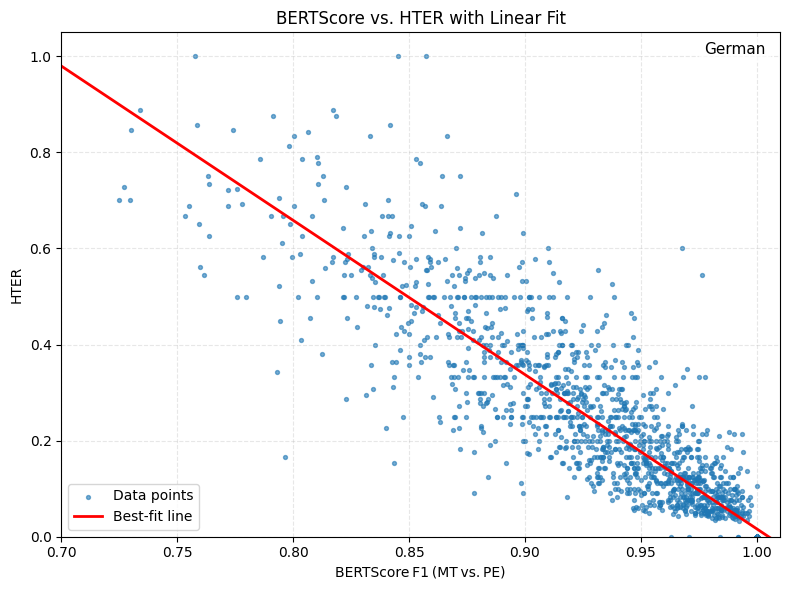

In [9]:
###############################################################################
# (B) PLOT BERTScore vs. HTER   —   tidy axes & clipped regression line
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("bertscore_vs_hter.csv")
x = df["out_ref"].values      # BERTScore F1
y = df["hter"].values         # HTER

x_lo = np.floor(x.min() * 20) / 20
x_hi = 1.01                                 # tiny pad above 1.0
y_lo, y_hi = 0.0, 1.05                      # small pad above 1.0

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, s=8, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x_lo, x_hi, 200)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)

ax.set_xlabel("BERTScore F1 (MT vs. PE)")
ax.set_ylabel("HTER")
ax.set_title("BERTScore vs. HTER with Linear Fit")

# language tag
ax.text(0.98, 0.98, "German",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

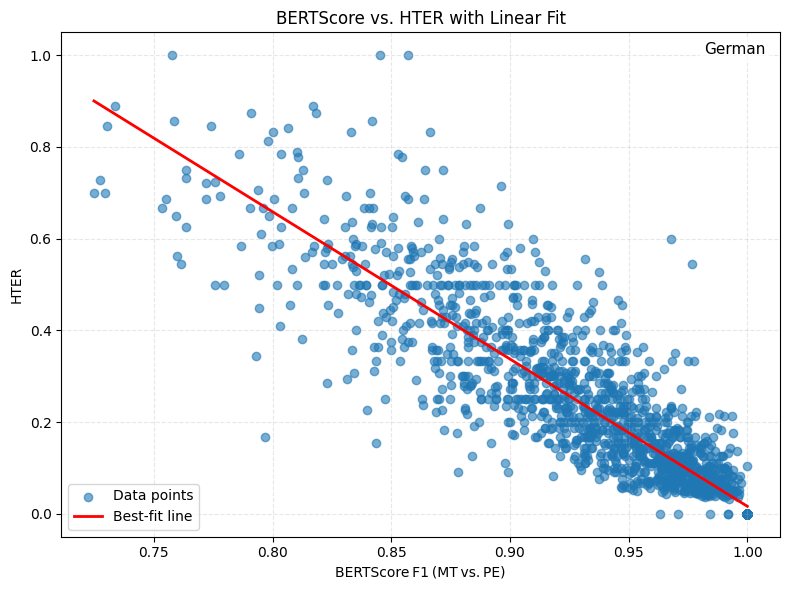

In [10]:
###############################################################################
# (B) PLOT BERTScore vs. HTER
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv("bertscore_vs_hter.csv")

x = df["out_ref"].values        # BERTScore F1 (MT vs. PE)
y = df["hter"].values           # HTER

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.text(0.98, 0.98, "German",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.set_xlabel("BERTScore F1 (MT vs. PE)")
ax.set_ylabel("HTER")
ax.set_title("BERTScore vs. HTER with Linear Fit")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# EN > ZH

## RSA Score compared to HTER: ZH

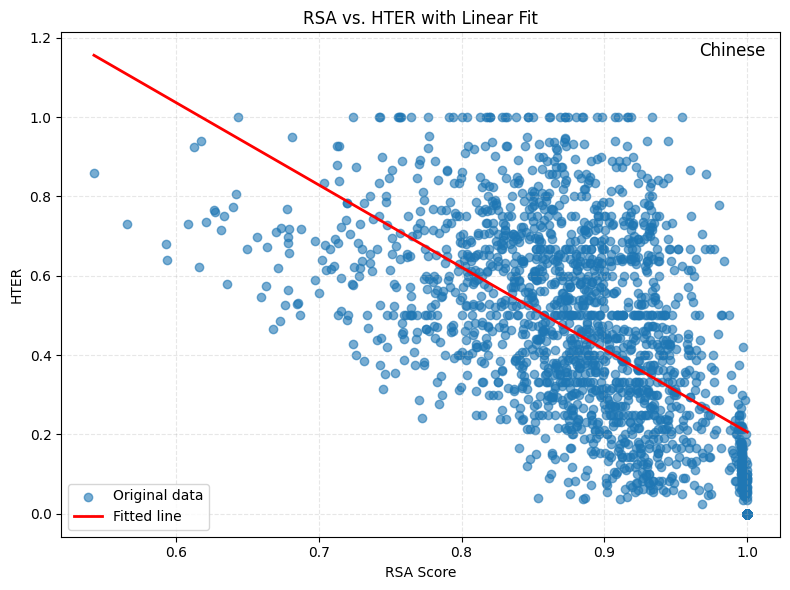

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv('results_ZH.csv')
#    expected columns: idx, src_out, src_ref, out_ref, hter, src, mt, pe, rsa

x = df['out_ref'].values
y = df['hter'].values

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, alpha=0.6, label='Original data')

slope, intercept = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='red', linewidth=2, label='Fitted line')

ax.set_xlabel('RSA Score')
ax.set_ylabel('HTER')
ax.set_title('RSA vs. HTER with Linear Fit')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

ax.text(0.98, 0.98, "Chinese",
        transform=ax.transAxes,        # use axes‑relative coordinates
        ha='right', va='top',          # align text to that corner
        fontsize=12,)

plt.tight_layout()
plt.show()


## chrF: ZH

In [4]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.8 MB/s eta 0:00:00


In [5]:
###############################################################################
# (A) COMPUTE chrF AND SAVE chrF‑vs‑HTER CSV
###############################################################################
import pandas as pd
import sacrebleu

df = (pd.read_csv("results_ZH.csv")
      .head(2000)                     # ← keep the first 2 000 examples
      .reset_index(drop=True)         # ← renumber the rows 0…1999
)       # cols: src, pe, mt, hter

chrf = sacrebleu.metrics.CHRF(beta=2)

out_ref_scores = []
for pe, mt in zip(df["pe"], df["mt"]):
    score = chrf.sentence_score(mt, [pe]).score / 100
    out_ref_scores.append(score)

out_df = pd.DataFrame({
    "src":      df["src"],
    "mt":       df["mt"],
    "pe":       df["pe"],
    "out_ref":  out_ref_scores,
    "hter":     df["hter"]
})

out_df.to_csv("chrf_vs_hter.csv", index=False)
print(f"Wrote {len(out_df)} rows → chrf_vs_hter.csv")

Wrote 2000 rows → chrf_vs_hter.csv


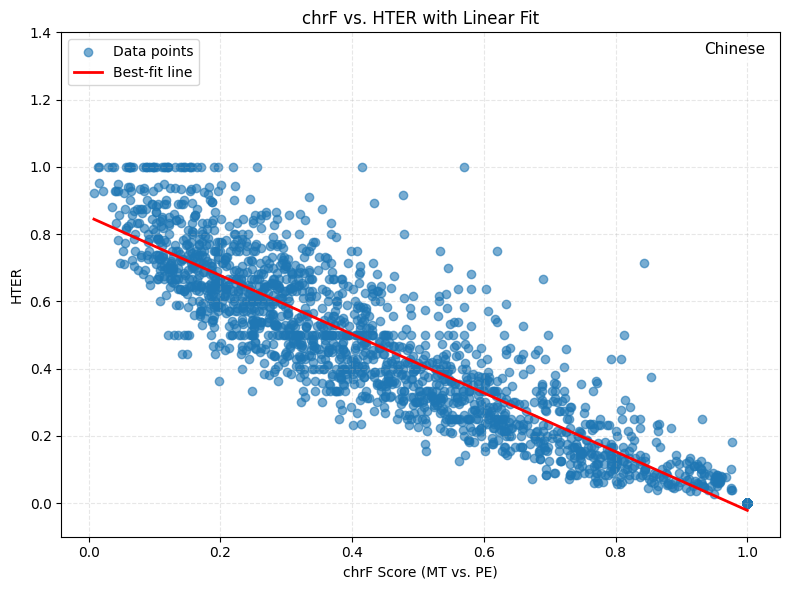

In [6]:
###############################################################################
# (B) PLOT chrF vs. HTER
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv("chrf_vs_hter.csv")

x = df["out_ref"].values
y = df["hter"].values

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.set_ylim(-0.1, 1.4)
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.text(0.98, 0.98, "Chinese", transform=ax.transAxes,
        fontsize=11, ha="right", va="top",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.set_xlabel("chrF Score (MT vs. PE)")
ax.set_ylabel("HTER")
ax.set_title("chrF vs. HTER with Linear Fit")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


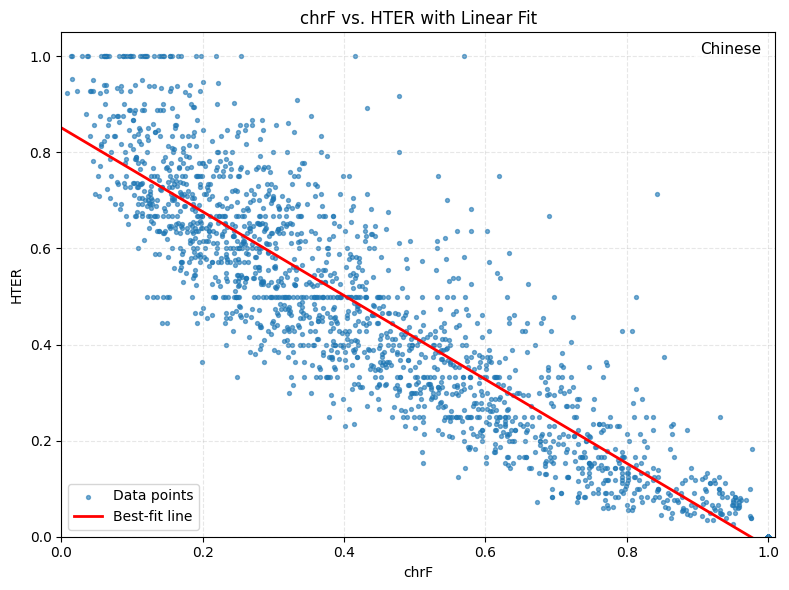

In [7]:
###############################################################################
# (B) PLOT BERTScore vs. HTER   —   tidy axes & clipped regression line
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("chrf_vs_hter.csv")
x = df["out_ref"].values
y = df["hter"].values

x_lo = np.floor(x.min() * 20) / 20
x_hi = 1.01
y_lo, y_hi = 0.0, 1.05

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, s=8, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x_lo, x_hi, 200)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)

ax.set_xlabel("chrF")
ax.set_ylabel("HTER")
ax.set_title("chrF vs. HTER with Linear Fit")

# language tag
ax.text(0.98, 0.98, "Chinese",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## BERTScore: ZH

In [8]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [9]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [11]:
###############################################################################
# (A) COMPUTE BERTScore AND SAVE BERTScore‑vs‑HTER CSV
###############################################################################
import pandas as pd
from evaluate import load

df = pd.read_csv("results_ZH.csv")         # cols: src, pe, mt, hter

bertscore = load("bertscore")
BERT_LANG = "zh"

scores = bertscore.compute(
    predictions=df["mt"].tolist(),
    references=df["pe"].tolist(),
    lang=BERT_LANG)["f1"]

out_df = pd.DataFrame({
    "src":      df["src"],
    "mt":       df["mt"],
    "pe":       df["pe"],
    "out_ref":  scores,
    "hter":     df["hter"]
})

out_df.to_csv("bertscore_vs_hter.csv", index=False)
print(f"Wrote {len(out_df)} rows → bertscore_vs_hter.csv")

Wrote 2000 rows → bertscore_vs_hter.csv


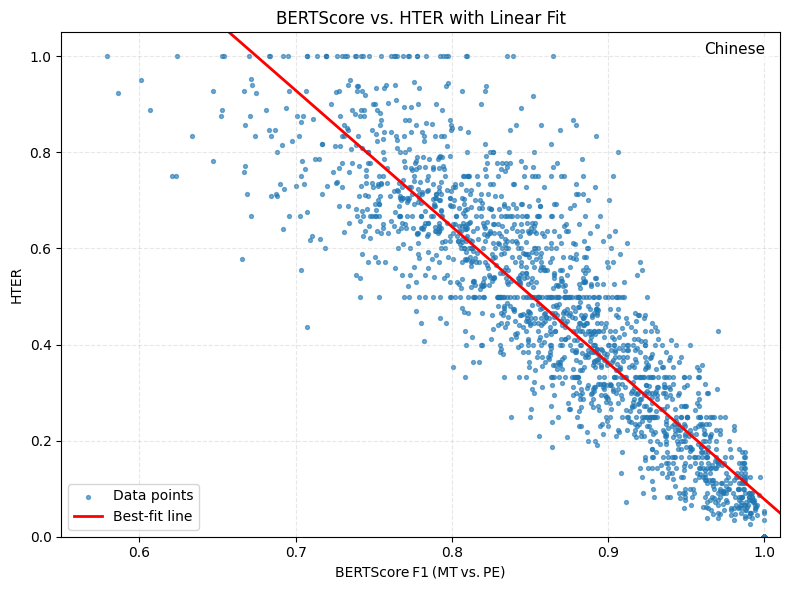

In [13]:
###############################################################################
# (B) PLOT BERTScore vs. HTER   —   tidy axes & clipped regression line
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("bertscore_vs_hter.csv")
x = df["out_ref"].values      # BERTScore F1
y = df["hter"].values         # HTER

x_lo = np.floor(x.min() * 20) / 20
x_hi = 1.01
y_lo, y_hi = 0.0, 1.05

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, s=8, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x_lo, x_hi, 200)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.set_xlim(x_lo, x_hi)
ax.set_ylim(y_lo, y_hi)

ax.set_xlabel("BERTScore F1 (MT vs. PE)")
ax.set_ylabel("HTER")
ax.set_title("BERTScore vs. HTER with Linear Fit")

# language tag
ax.text(0.98, 0.98, "Chinese",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

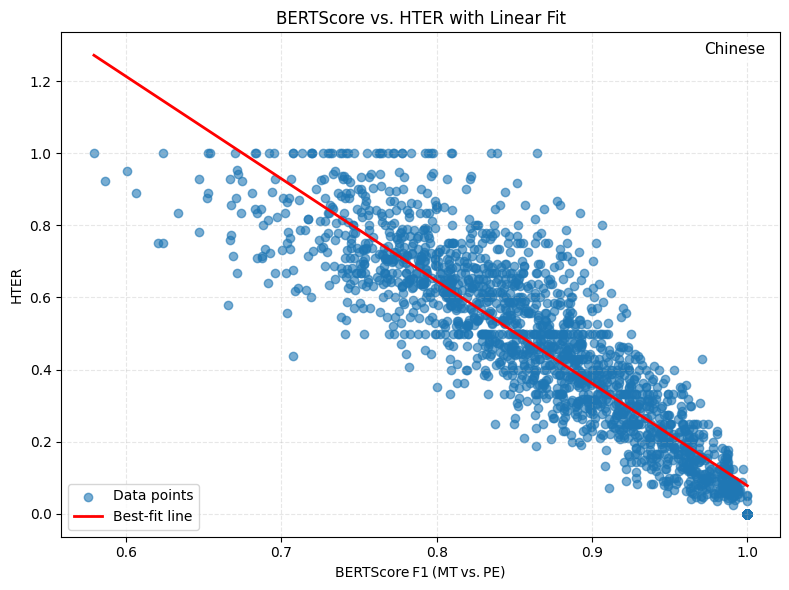

In [14]:
###############################################################################
# (B) PLOT BERTScore vs. HTER
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv("bertscore_vs_hter.csv")

x = df["out_ref"].values        # BERTScore F1 (MT vs. PE)
y = df["hter"].values           # HTER

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.6, label="Data points")

slope, intercept = np.polyfit(x, y, 1)

x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, "-", color="red", linewidth=2, label="Best‑fit line")

ax.text(0.98, 0.98, "Chinese",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.set_xlabel("BERTScore F1 (MT vs. PE)")
ax.set_ylabel("HTER")
ax.set_title("BERTScore vs. HTER with Linear Fit")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# Pearson's Correlation between scores and HTER

In [15]:
import pandas as pd

csv_path = 'all_scores_test.csv'
df = pd.read_csv(csv_path, sep=';')

numeric_cols = ['chrF', 'BertScore', 'RSA', 'hter']

df[numeric_cols] = df[numeric_cols].apply(
    lambda s: s.str.strip() if s.dtype == 'object' else s
)

df[numeric_cols] = df[numeric_cols].apply(
    pd.to_numeric, errors='coerce'
)

df.dropna(subset=numeric_cols, inplace=True)

print("Data ready → dtypes:\n", df.dtypes, "\nFirst 3 rows:\n", df.head(3))

from scipy.stats import pearsonr

for metric in ['chrF', 'BertScore', 'RSA']:
    r, p = pearsonr(df[metric], df['hter'])
    print(f'{metric:10s} vs. hter:\t r = {r:.3f}  (p = {p:.3g})')

Data ready → dtypes:
 chrF         float64
BertScore    float64
RSA          float64
hter         float64
dtype: object 
First 3 rows:
        chrF  BertScore       RSA      hter
0  0.564836   0.812381  0.921220  0.380952
1  0.862888   0.976562  0.910917  0.083333
2  0.818667   0.936350  0.941856  0.187500
chrF       vs. hter:	 r = -0.923  (p = 0)
BertScore  vs. hter:	 r = -0.589  (p = 0)
RSA        vs. hter:	 r = -0.715  (p = 0)


In [17]:
from scipy.stats import pearsonr

correlation_chrF      = pearsonr(df['chrF'],      df['hter'])
correlation_BERTScore = pearsonr(df['BertScore'], df['hter'])
correlation_RSA       = pearsonr(df['RSA'],       df['hter'])

print(f"chrF       vs. hter:\tρ = {correlation_chrF.correlation:.3f}  (p = {correlation_chrF.pvalue:.3g})")
print(f"BERTScore  vs. hter:\tρ = {correlation_BERTScore.correlation:.3f}  (p = {correlation_BERTScore.pvalue:.3g})")
print(f"RSA        vs. hter:\tρ = {correlation_RSA.correlation:.3f}  (p = {correlation_RSA.pvalue:.3g})")

chrF       vs. hter:	ρ = -0.923  (p = 0)
BERTScore  vs. hter:	ρ = -0.589  (p = 0)
RSA        vs. hter:	ρ = -0.715  (p = 0)


In [18]:
print(f"chrF:\t\t{correlation_chrF.statistic:.3f}")
print(f"BERTScore:\t{correlation_BERTScore.statistic:.3f}")
print(f"RSA:\t\t{correlation_RSA.statistic:.3f}")

chrF:		-0.923
BERTScore:	-0.589
RSA:		-0.715


In [16]:
# sanity check
df[['chrF', 'BertScore', 'RSA', 'hter']].describe()

,chrF,BertScore,RSA,hter
count,3999.000000,3999.000000,3999.000000,3999.000000
mean,0.656119,0.911668,0.920467,0.307087
std,0.293194,0.081064,0.073539,0.268293
min,0.007974,0.579358,0.542781,0.000000
25%,0.407996,0.857633,0.877001,0.062500
50%,0.710277,0.928021,0.928800,0.250000
75%,0.936469,0.985467,0.996348,0.500000
max,1.000000,1.000000,1.000000,1.000000
